# Visualization of CNN Layers and Filters

### FROM https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

## Outline
1. Using torchvision.datasets with a custom folder of images
2. Occlusion analysis with pretrained model
3. Filter visualisation with pretrained model

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [10]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv2d(3, 40, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.conv2 = nn.Conv2d(40, 60, 5)
        self.conv3 = nn.Conv2d(60, 240, 3)
        self.resnet = nn.Linear(240, 240)  # NOT ACTUALLY RESNET
        self.fc1 = nn.Linear(240, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 1)
    
    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        # x = self.drop(x)

        # Best result so far
        x = F.relu(self.resnet(x))
        x = F.relu(self.resnet(x))



        # 1 Layer Resnet did perform very well
        # x = F.relu(self.resnet(F.relu(self.resnet(x)))) + x
        # x = F.relu(self.resnet(F.relu(self.resnet(x)))) + x
        # x = self.drop(x)
        # x = F.relu(self.resnet(F.relu(self.resnet(x)))) + x
        # x = self.drop(x)
        # x = F.relu(self.resnet(F.relu(self.resnet(x)))) + x
        # x = self.drop(x)
        # x = F.relu(self.resnet(F.relu(self.resnet(x)))) + x


        x = F.relu(self.fc1(x))
        # x = self.drop(x)
        x = F.relu(self.fc2(x))
        # x = self.drop(x)
        x = self.fc3(x)
        # no activation and no softmax at the end
        return x
    


## Load pretrained model

In [55]:
#for visualization we will use vgg16 pretrained on imagenet data

device = torch.device('cpu')
model = NeuralNet(57600, 1)
model.load_state_dict(torch.load('/home/jiawenb/CS229/cs229-project/CNN_MLP_trained_model.pt', map_location=device))

<All keys matched successfully>

In [56]:
model.eval()

NeuralNet(
  (conv1): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(40, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(60, 240, kernel_size=(3, 3), stride=(1, 1))
  (resnet): Linear(in_features=240, out_features=240, bias=True)
  (fc1): Linear(in_features=240, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=1, bias=True)
)

## Visualise image

In [57]:
def imshow(img, title):
  
  """Custom function to display the image using matplotlib"""
  
  #define std correction to be made
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  
  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [58]:
#custom function to fetch images from dataloader

def show_batch_images(dataloader):
  images,_ = next(iter(dataloader))
  
  #run the model on the images
  outputs = model(images)
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  
  #make grid
  img = torchvision.utils.make_grid(images)
  
  #call the function
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred

## Filter visualisation

In [59]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [60]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    plt.savefig('myimage.png', dpi=100)  
   
    plt.tight_layout()
    plt.show()

In [61]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [62]:
def plot_weights(model, layer, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  # layer = model.conv1
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

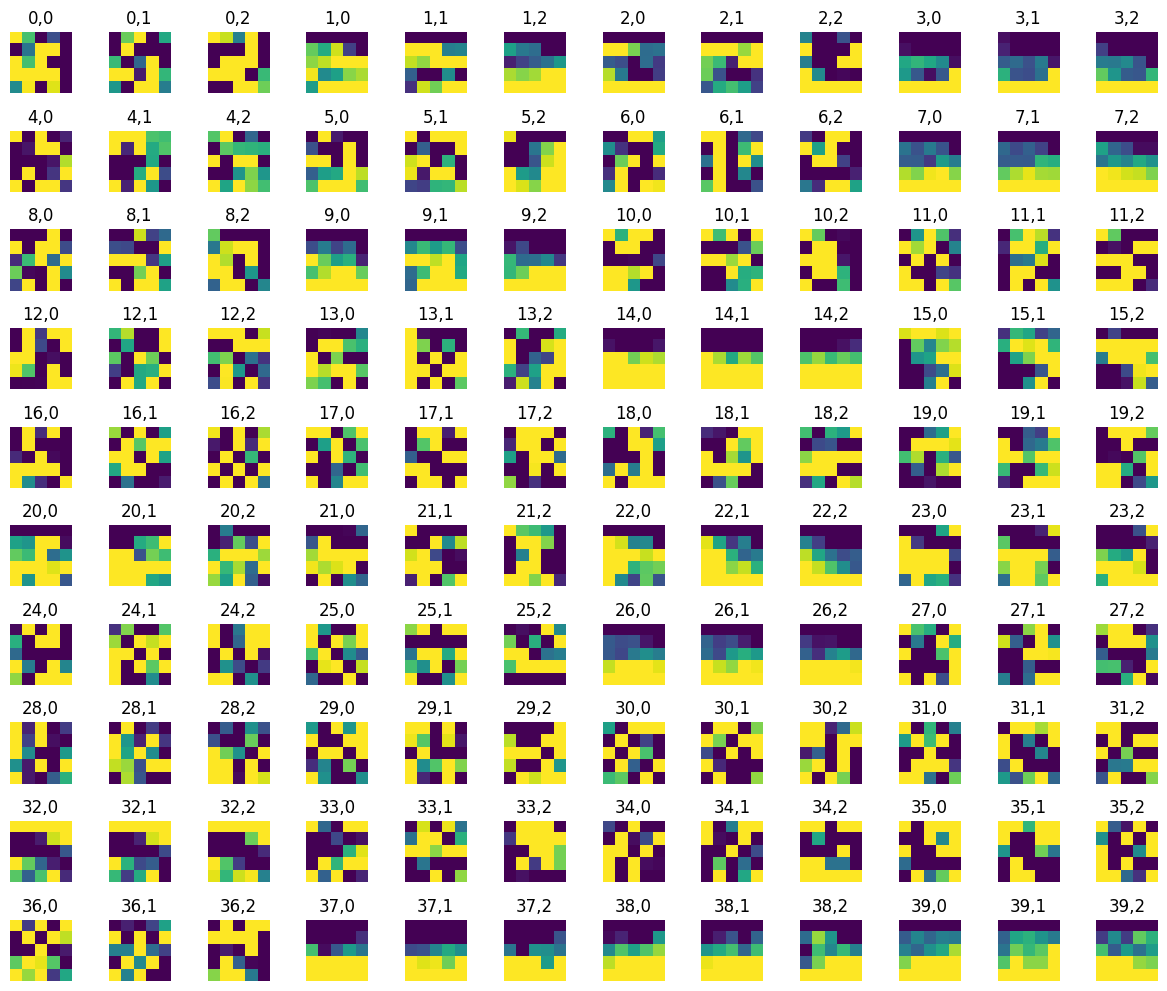

In [63]:
#visualize weights for the model - first conv layer

plot_weights(model, model.conv1, single_channel = True)